In [43]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [44]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [45]:
len(words)

32033

In [46]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [47]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [48]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) #* 0.2
#b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01 # brings logits closer to zero for first iteration
b2 = torch.randn(vocab_size,                      generator=g) * 0 # make sure b2 is zero at initialization

# BatchNorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12097


In [49]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
  # BatchNorm layer
  # -------------------------------------------------------------
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
  # -------------------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

  # TODO REMOVE ME
  break

      0/ 200000: 3.3239


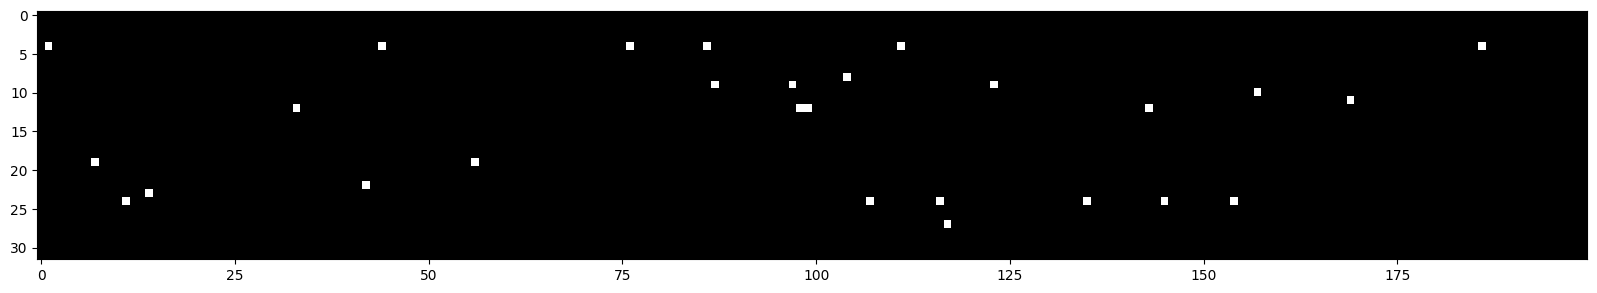

In [50]:
# to see if our model is good, we calculate what we expect for the loss in the first round
# for 27 characters that could come next, we can expect uniform probability for all 27 characters
# -> negative log probability of this is:
-torch.tensor(1/27.0).log()

# to optimize the model need to look at each layer

# 1) fixing logits at initialization
# the first layer has distributions in w2/b2 has values that are too big, so we see large values in logits
# so the weights and bias initialization can be tuned to help with the first training round if the values are closer to 0-1
#W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01 # brings logits closer to zero for first iteration
#b2 = torch.randn(vocab_size,                      generator=g) * 0 # make sure b2 is zero at initialization
# we do not want to set Ws to 0, only biases, things can go wrong with initial zeros on weights

# 2) optimizing distribution in h (tanh layer is too saturated at init)
#  looking at h to see if we have most of values at 1 or -1, so have a lot of values at the borders of tanh
# plt.hist(h.view(-1).tolist(), 50)
# we can also look at the pre reaction how the distributin looks
# plt.hist(hpreact.view(-1).tolist(), 50)
# tanh with values close to 1 or -1 just drop the gradient on backwards
# so we want a good distribution of the values
# visualize, white = true, black = false
plt.figure(figsize=(20,10)) 
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')
# so we want to see only a few white ones. White neurons are basically "dead neurons"
# we need to make sure that this does not happen on initialization
# but also during training. If you change the W/b are never triggering activation functions, the neuron is also "dead"
# fix is again to smaller the W1, b1
# W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.2
# b1 = torch.randn(n_hidden,                        generator=g) * 0.01

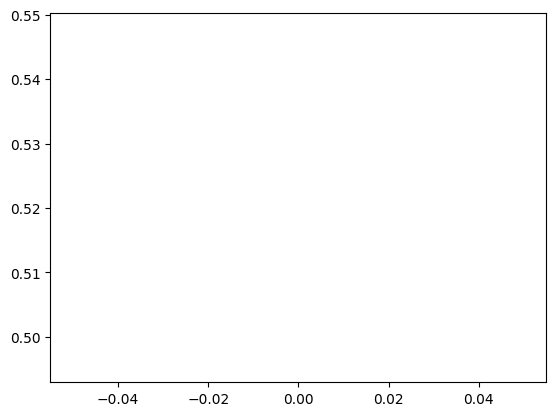

In [51]:
plt.plot(lossi)
# we don't want to see a hockey-stick here (first iteration is massively going down at first)

In [52]:
# calibrate the batch norm at the end of training
with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 # + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)


In [53]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 # + b1
  #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 3.270019769668579
val 3.269137144088745


tensor(0.0017) tensor(0.9886)
tensor(0.0076) tensor(3.1632)


(array([6.76091640e-06, 0.00000000e+00, 6.76091640e-06, 2.02827492e-05,
        6.76091640e-05, 5.40873312e-05, 1.82544743e-04, 2.29871158e-04,
        4.12415901e-04, 5.81438811e-04, 1.16287762e-03, 1.79840376e-03,
        2.75845389e-03, 4.72588057e-03, 7.98464227e-03, 1.20952794e-02,
        1.76324700e-02, 2.75372125e-02, 3.86048327e-02, 5.46958137e-02,
        7.27880260e-02, 9.26989248e-02, 1.13691570e-01, 1.29234917e-01,
        1.35468482e-01, 1.33757970e-01, 1.21622125e-01, 1.02745647e-01,
        8.17056747e-02, 6.24776285e-02, 4.53454663e-02, 3.12016292e-02,
        2.13239303e-02, 1.36097247e-02, 8.85003957e-03, 5.84819269e-03,
        3.59004661e-03, 2.27166791e-03, 1.43331428e-03, 6.96374389e-04,
        4.59742315e-04, 3.11002155e-04, 1.89305659e-04, 1.08174662e-04,
        9.46528296e-05, 2.02827492e-05, 2.70436656e-05, 6.76091640e-06,
        2.02827492e-05, 2.70436656e-05]),
 array([-18.26543045, -17.52588573, -16.78634102, -16.0467963 ,
        -15.30725159, -14.5677

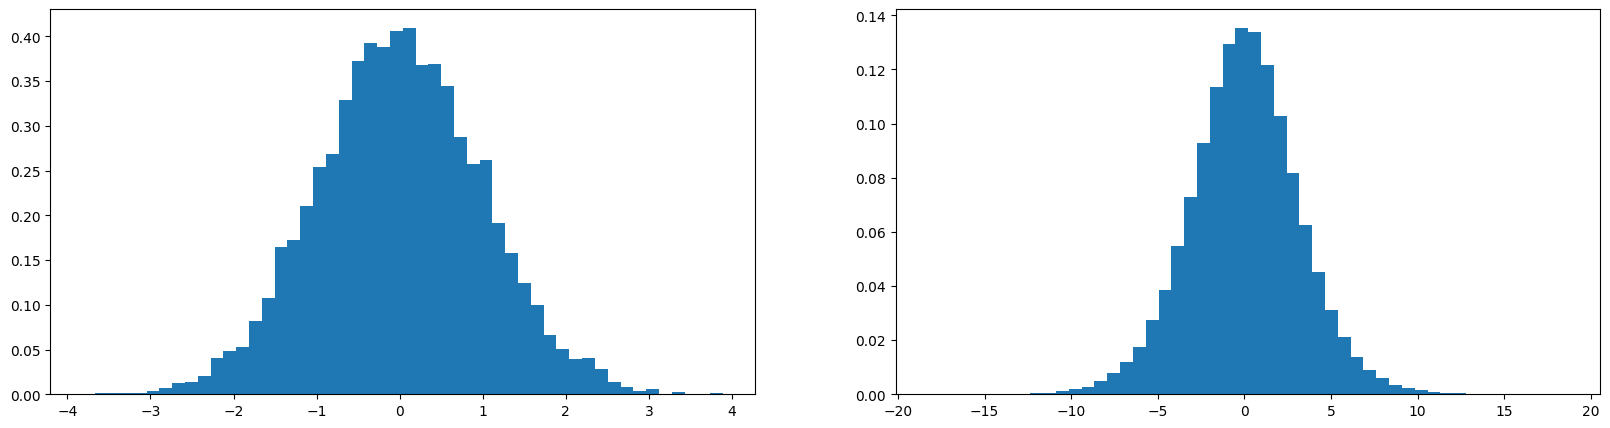

In [55]:
# 3) how can we do the modifications more determined instead of random guesses

x = torch.randn(1000, 10)
w = torch.randn(10, 200)
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True)

# when we multiply neuron * weights, we widen the gaussian distribution
# but we want narrow distribution in MLPs
# for this we can smaller the weights again using the square root of the inputs
# e.g.
# w = torch.randn(10, 200) / 10**0.5 # (square root)

# we can do even better, looking at the exact std gain, that is based on the
# linearity mode. For tanh it is (5/3) / fan_in**0.5
# W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) #* 0.2

In [57]:
# today this is solved within pytorch and other libraries, so you can initialize
# models without considering a lot of this


In [ ]:
# people have frist started using batch-normalization
# there you do redistribute the values to gaussian before inputting to tanh
# because we do normalization on the layer, there is no need for bias as it is going to be subtracted anyway
# b1 can be omitted in our example here